<a href="https://colab.research.google.com/github/helonayala/sysid/blob/main/grey_box_activity_2a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solution - Activity 2a

In [3]:
#!pip install diffrax # run only once in colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.2/193.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 6.3 MB/s eta 0:00:00


In [4]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm # For the progress bar
import os
import scipy.io
import numpy as np # Good practice to import, especially if .ravel() is needed

# JAX for automatic differentiation and high-performance computation
import jax
try:
    print(f"JAX is running on: {jax.devices()[0].platform.upper()}")
except IndexError:
    print("No JAX devices found.")
import jax.numpy as jnp

# Diffrax for high-performance, differentiable ODE solvers
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, LinearInterpolation

# Set JAX to use 64-bit precision for better solver accuracy
jax.config.update("jax_enable_x64", True)

JAX is running on: GPU


# read bah data

In [5]:
def process_and_plot_mat_file(file_url):

  local_filename = os.path.basename(file_url)

  # --- 1. Download the .mat file ---
  print(f"Downloading {file_url} as {local_filename}...")
  # Use -O to specify the output file, overwriting if it exists. -q for quiet.
  # Adding !rm -f to ensure a clean download if the cell is re-run.
  get_ipython().system(f"rm -f {local_filename}") # Remove if exists to ensure fresh download
  get_ipython().system(f"wget -q -O {local_filename} '{file_url}'")

  # Check if download was successful
  if not os.path.exists(local_filename):
      print(f"Error: File '{local_filename}' not found after attempting download. Please check the URL and wget command.")
  else:
      print(f"File '{local_filename}' downloaded successfully.")

      # --- 2. Load the .mat file and Extract Data ---
      try:
          print(f"Loading data from '{local_filename}'...")
          mat_data = scipy.io.loadmat(local_filename)
          print("File loaded. Extracting variables...")

          time_data = mat_data['time'].reshape(-1,1)
          u_data = mat_data['u'].reshape(-1,1)
          y_data = mat_data['y'].reshape(-1,1)
          # Check if 'yref' key exists and its content is not empty
          yref_data_raw = mat_data.get('yref')
          if yref_data_raw is not None and hasattr(yref_data_raw, 'size') and yref_data_raw.size > 0:
              yref_data = yref_data_raw.reshape(-1,1)
              flag_yref= 1
              print("Found 'yref' data.")
          else:
              yref_data = np.array([]) # Assign an empty numpy array if not found or empty
              flag_yref= 0
              print("No 'yref' data found or 'yref' was empty/None. Using empty array for yref_data.")

      except FileNotFoundError:
          # This case should be caught by the os.path.exists check earlier,
          # but good to have as a fallback for scipy.io.loadmat.
          print(f"Error: Could not find '{local_filename}' to load. Ensure download was successful.")
      except KeyError as e:
          # This handles cases where loadmat succeeds but specific keys are missing
          # (now partially handled by the explicit key check above, but good as a catch-all).
          print(f"KeyError: Variable {e} not found in the .mat file.")
          if 'mat_data' in locals(): # Check if mat_data was loaded
              print(f"Available keys in .mat file: {list(mat_data.keys())}")
      except Exception as e:
          print(f"An unexpected error occurred: {e}")
  return time_data, u_data, y_data, yref_data

# URL of the .mat file
file_url = 'https://github.com/helonayala/sysid/raw/refs/heads/main/data/randomStepSequence.mat'

time, u, y, _ = process_and_plot_mat_file(file_url)

time = time.reshape(-1)
u = u.reshape(-1)
y = y.reshape(-1)

# Signal generation parameters
# N = 2048  # Number of samples (power of 2 is efficient for FFT)
N = time.shape[0]
Ts = time[1]-time[0]
fs = 1/Ts
T = time[-1]  # Total time in seconds

print(N, fs, T, Ts)


File 'randomStepSequence.mat' downloaded successfully.
Loading data from 'randomStepSequence.mat'...
File loaded. Extracting variables...
No 'yref' data found or 'yref' was empty/None. Using empty array for yref_data.
8150 10.0 814.9000000000001 0.1


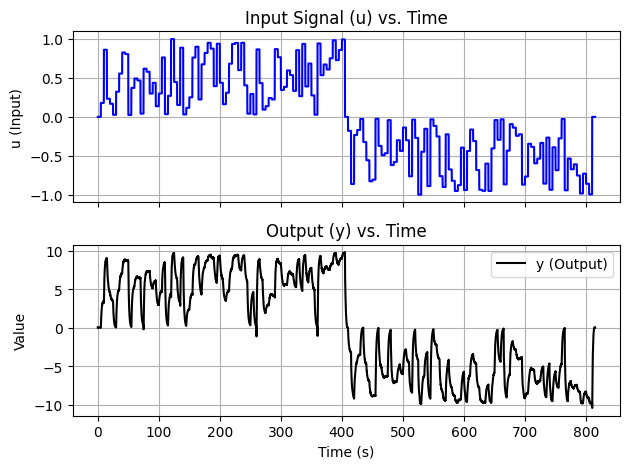

In [6]:
# prompt: plot the data we just loaded (time, u, y)

import matplotlib.pyplot as plt
# --- 3. Plotting ---
# Using explicit figure and axes creation for more control
fig, axs = plt.subplots(2, 1, sharex=True) # sharex makes sense for time series

# Plot 1: Input u
axs[0].plot(time, u, color='b') # Added color for clarity
axs[0].set_title('Input Signal (u) vs. Time')
axs[0].set_ylabel('u (Input)')
axs[0].grid(True)

# Plot 2: Output y and Reference yref
axs[1].plot(time, y, 'k', label='y (Output)')
axs[1].set_title('Output (y) vs. Time')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Value')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout() # Adjusts subplot params for a tight layout
plt.show()

## Multiple Shooting Model Implementation

Here we define the core JAX functions for the objective and constraints. The data is reshaped into batches corresponding to the multiple shooting intervals. A key element is the use of `diffrax.LinearInterpolation` to handle the time-varying input signal within the differentiable ODE solver.

In [10]:
n_shots = 163 # 8150 / 163 = 50 data points per shot.
n_timesteps_per_shot = N // n_shots

# Reshape data into batches for multiple shooting
t_shots = jnp.array(time.reshape(n_shots, n_timesteps_per_shot))
y_data = jnp.array(y.reshape(n_shots, n_timesteps_per_shot))

# Create a differentiable interpolation object for the input signal
u_interpolation = LinearInterpolation(ts=time, ys=u)

# The JAX-compatible model evaluates the interpolated input u at any time t
def dc_motor_model_jax(t, w, args):
    theta1, theta2, theta3, u_interp = args
    u = u_interp.evaluate(t)
    return theta1 * w + theta2 * jnp.power(w, 3) +  theta3 * u

term = ODETerm(dc_motor_model_jax)
solver = Dopri5()

def create_loss_and_constraint_fns(t_shots, y_data, u_interp):
    """A factory to create the objective and constraint functions."""
    @jax.jit
    def objective_jax(decision_vars):
        theta1, theta2, theta3 = decision_vars[:3]
        w_initial_shots = decision_vars[3:]

        def simulate_shot(t_shot, w0):
            saveat = SaveAt(ts=t_shot)
            args = (theta1, theta2, theta3, u_interp)
            sol = diffeqsolve(term, solver, t0=t_shot[0], t1=t_shot[-1], dt0=Ts, y0=w0, saveat=saveat, args=args)
            return sol.ys.flatten()

        w_pred = jax.vmap(simulate_shot)(t_shots, w_initial_shots)
        return jnp.sum((w_pred - y_data)**2)

    @jax.jit
    def continuity_constraints_jax(decision_vars):
        theta1, theta2, theta3 = decision_vars[:3]
        w_initial_shots = decision_vars[3:]

        def get_end_state(t_shot, w0):
            args = (theta1, theta2, theta3, u_interp)
            sol = diffeqsolve(term, solver, t0=t_shot[0], t1=t_shot[-1], dt0=Ts, y0=w0, args=args)
            return sol.ys[-1]

        w_end_of_shots = jax.vmap(get_end_state)(t_shots[:-1], w_initial_shots[:-1])
        # The continuity constraints are the differences between the end state of a shot
        # and the initial state of the next shot.
        return (w_end_of_shots - w_initial_shots[1:]).flatten()

    return objective_jax, continuity_constraints_jax

# Create the specific functions for our data
objective_jax, continuity_constraints_jax = create_loss_and_constraint_fns(t_shots, y_data, u_interpolation)

# Create JIT-compiled gradient and Jacobian functions
objective_grad_func = jax.jit(jax.value_and_grad(objective_jax))
# We use jacrev (reverse-mode AD) as it's compatible with the adjoint-based diffrax solver
# Reshape the output of jacrev to match the expected shape for the constraints Jacobian
constraints_jac_func = jax.jit(jax.jacrev(continuity_constraints_jax))

### Part 3.3: Parameter Identification and Results

With all components defined, we run the `scipy.optimize.minimize` solver. Wrapper functions are used to interface between SciPy's NumPy-based inputs and our JAX-based functions. A `tqdm` progress bar provides feedback on the optimization progress.

In [12]:
# Wrapper functions to interface between SciPy (NumPy) and JAX
def obj_for_scipy(dv_np):
    val, grad = objective_grad_func(jnp.array(dv_np))
    return np.array(val), np.array(grad)

def cons_for_scipy(dv_np):
    return np.array(continuity_constraints_jax(jnp.array(dv_np)))

def cons_jac_for_scipy(dv_np):
    jac_jax = constraints_jac_func(jnp.array(dv_np))
    # SciPy expects the Jacobian to be a 2D array where rows correspond to constraints
    # and columns correspond to decision variables.
    # jax.jacrev might return a nested structure depending on the output of the function.
    # We need to flatten it to the expected 2D shape.
    # Use ravel_pytree to flatten the nested Jacobian structure
    flat_jac, _ = jax.flatten_util.ravel_pytree(jac_jax)
    # Reshape the flattened Jacobian to the expected 2D shape (num_constraints, num_decision_vars)
    num_constraints = len(cons_for_scipy(dv_np))
    num_decision_vars = len(dv_np)
    return np.array(flat_jac).reshape(num_constraints, num_decision_vars)


# Set up the optimization problem
initial_guess_np = np.concatenate([[-0.6292, -0.1, 7.2858], np.zeros(n_shots)])
cons = ({'type': 'eq', 'fun': cons_for_scipy, 'jac': cons_jac_for_scipy})

# Run the optimization with a progress bar
max_iterations = 50
with tqdm(total=max_iterations, desc="Optimizing Parameters") as pbar:
    def callback(xk):
        pbar.update(1)

    print("--- Running Optimization with Automatic Differentiation ---")
    result = minimize(obj_for_scipy,
                      initial_guess_np,
                      method='SLSQP',
                      jac=True, # Tells SciPy that our objective function returns value and gradient
                      constraints=cons,
                      options={'maxiter': max_iterations, 'disp': False}, # Set disp=False for cleaner output with tqdm
                      callback=callback)

print("\nOptimization finished with status:", result.message)

Optimizing Parameters:   0%|          | 0/50 [00:00<?, ?it/s]

--- Running Optimization with Automatic Differentiation ---


Optimizing Parameters:  50%|█████     | 25/50 [00:32<00:32,  1.28s/it]


Optimization finished with status: Optimization terminated successfully



--- Identification Results ---
Estimated parameters: theta1 = -0.4925, theta2 = -0.0045, theta3 = 8.9952


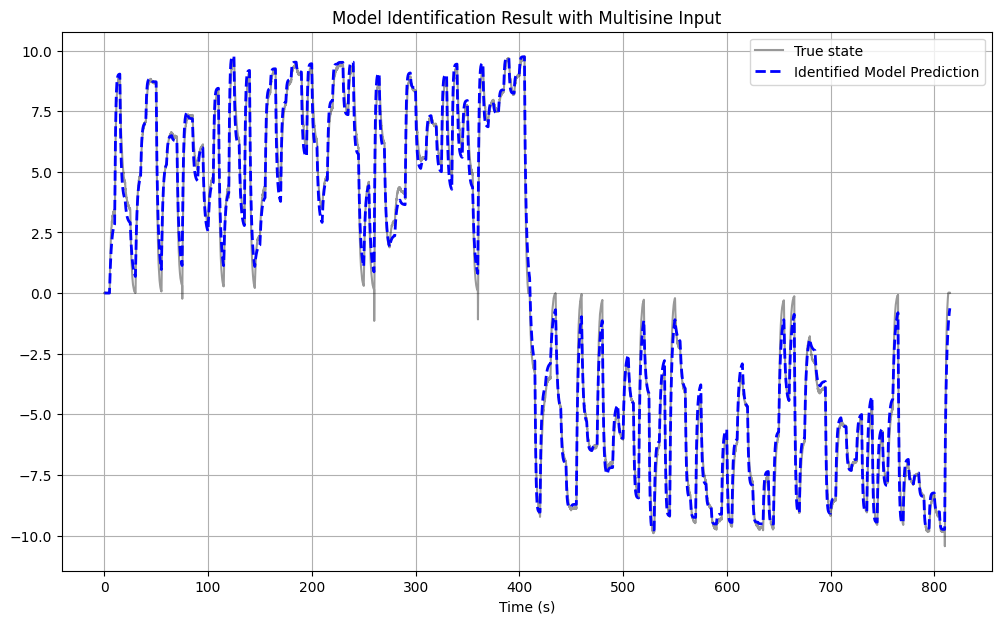

In [14]:
# Extract and display results
theta1_est, theta2_est, theta3_est = result.x[:3]

print("\n--- Identification Results ---")
print(f"Estimated parameters: theta1 = {theta1_est:.4f}, theta2 = {theta2_est:.4f}, theta3 = {theta3_est:.4f}")

# Simulate the final model prediction
final_args = (theta1_est, theta2_est, theta3_est, u_interpolation)
final_sol = diffeqsolve(term, solver, t0=time[0], t1=time[-1], dt0=Ts, y0=y[0], saveat=SaveAt(ts=jnp.array(time)), args=final_args, max_steps=16384)
# final_sol = diffeqsolve(term, solver, t0=time[0], t1=time[-1], dt0=Ts, y0=y[0], saveat=SaveAt(ts=jnp.array(time)), args=final_args)
yhat = final_sol.ys.flatten()

# Plot final results
plt.figure(figsize=(12, 7))
plt.plot(time, y, 'k', label='True state', alpha=0.4)
plt.plot(time, yhat, 'b--', label='Identified Model Prediction', linewidth=2)
plt.xlabel('Time (s)')
plt.title('Model Identification Result with Multisine Input')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipython-input-15-663403920.py:58: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, fs / 2) # Show up to the Nyquist frequency


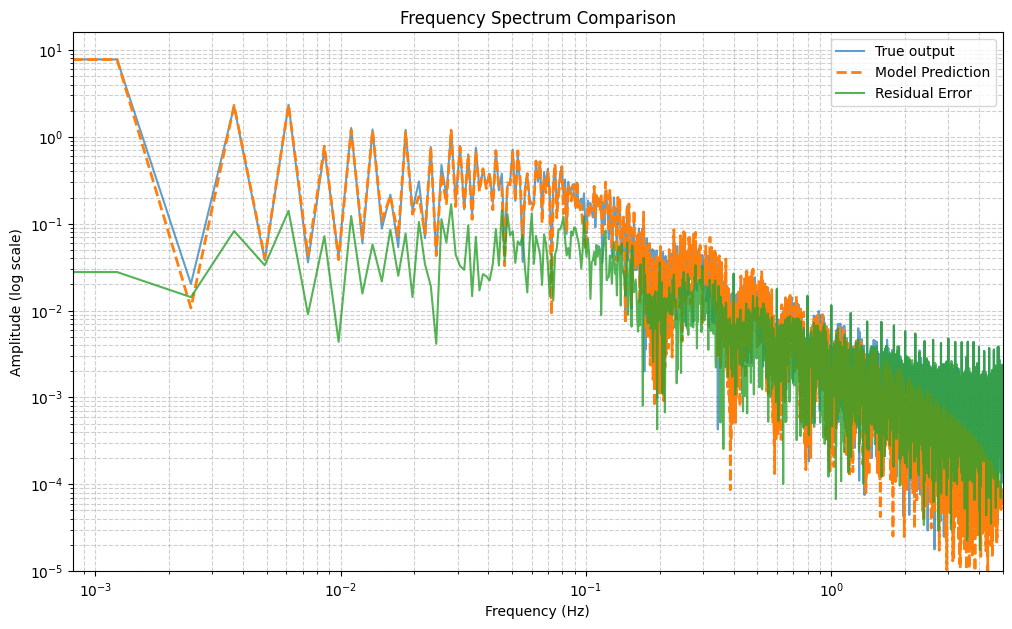

In [15]:
# First, define the residual signal (the error between measurement and prediction)
y_residual = y - yhat

# Helper function to compute the single-sided amplitude spectrum of a signal
def calculate_amplitude_spectrum(signal, sampling_freq):
    """
    Computes the single-sided amplitude spectrum of a signal using FFT.

    Args:
        signal (np.ndarray): The input time-domain signal.
        sampling_freq (float): The sampling frequency in Hz.

    Returns:
        tuple: A tuple containing the frequencies (Hz) and the amplitudes.
    """
    N = len(signal)
    if N == 0:
        return np.array([]), np.array([])

    # Compute the Fast Fourier Transform
    fft_vals = np.fft.fft(signal)

    # Compute the frequency bins
    freqs = np.fft.fftfreq(N, 1 / sampling_freq)

    # We only care about the positive frequencies for the single-sided spectrum
    positive_freq_indices = np.where(freqs >= 0)
    freqs = freqs[positive_freq_indices]
    fft_vals = fft_vals[positive_freq_indices]

    # Calculate the amplitude
    # The amplitude is scaled by 2/N to account for energy in negative frequencies.
    # The DC component (at freq=0) is not doubled.
    amplitudes = np.abs(fft_vals) / N
    if N > 1:
      amplitudes[1:] *= 2

    return freqs, amplitudes

# Calculate the spectrum for each signal
freqs, amp_y = calculate_amplitude_spectrum(y, fs)
_, amp_pred = calculate_amplitude_spectrum(yhat, fs)
_, amp_residual = calculate_amplitude_spectrum(y_residual, fs)

# --- Plot the Frequency Spectra ---
plt.figure(figsize=(12, 7))

# A semilog plot is best for viewing a wide dynamic range of amplitudes
plt.loglog(freqs, amp_y, label='True output', alpha=0.7)
plt.loglog(freqs, amp_pred, label='Model Prediction', linestyle='--', linewidth=2)
plt.loglog(freqs, amp_residual, label='Residual Error', alpha=0.8)

plt.title('Frequency Spectrum Comparison')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (log scale)')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.xlim(0, fs / 2) # Show up to the Nyquist frequency
plt.ylim(bottom=1e-5) # Set a lower limit to avoid plotting near zero
plt.show()